# Project Code

## Installing Necessary Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, mean_squared_error, accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import time
import seaborn as sns
from sklearn.svm import SVC



## Dataset Selection and Preparation
The dataset comprises seven independent variables and is designed for binary classification. The previous dataset from the previous subject SEP 720 was excluded from use because it was unsuitable for the classification task. The current dataset contains maintenance data for the machine and is intended to classify whether or not machine failure has occurred.

In [7]:
df = pd.read_csv('gs://sep_721_project/project_data.csv')


In [8]:
df.head()

,UDI,Product ID,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure
0,51,47230,298.9,309.1,2861,4.6,143,1
1,70,47249,298.9,309.0,1410,65.7,191,1
2,78,47257,298.8,308.9,1455,41.3,208,1
3,161,47340,298.4,308.2,1282,60.7,216,1
4,162,47341,298.3,308.1,1412,52.3,218,1


In [10]:
# Split the data into training and testing sets
X = df.iloc[:, :-1]
y = df.iloc[:, -1]


# Normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the normalized data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, random_state=42)

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

## Exploratory data analysis

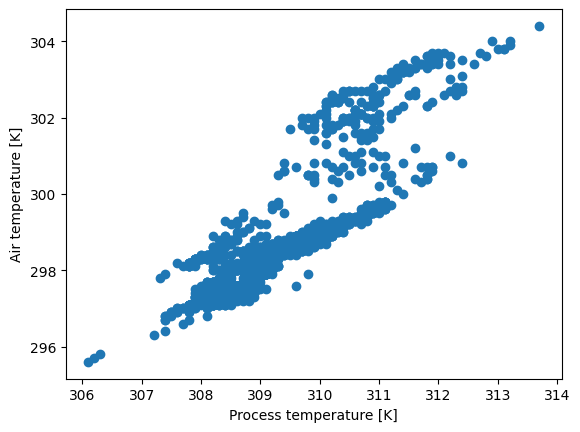

In [11]:
plt.scatter(df['Process temperature [K]'], df['Air temperature [K]'])
plt.xlabel('Process temperature [K]')
plt.ylabel('Air temperature [K]')
plt.show()

### EDA Plot 1 (Air temperature [K] - Process temperature [K])
The given scatter plot provides a visual representation of the distribution of ambient air temperature and the corresponding process inside that is linked to the machine parameter. The temperature unit utilized in the plot is Kelvin.

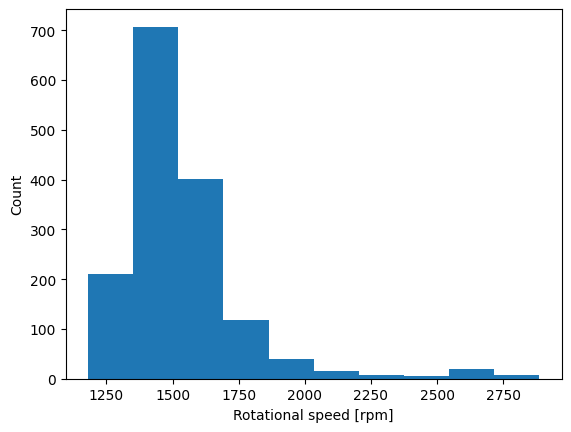

In [12]:
plt.hist(df['Rotational speed [rpm]'])
plt.xlabel('Rotational speed [rpm]')
plt.ylabel('Count')
plt.show()


### EDA Plot 2 (Rotational Speed - Instances )
The bar graph displays the vibration and rotation parameters of a machine, with emphasis on the critical vibration parameter ranging from 1200 to 2800 rpm. Proper management of the vibration parameter is vital for the machine's optimal performance and longevity.

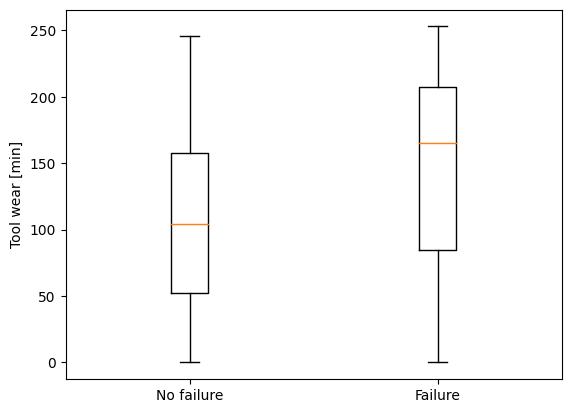

In [13]:
plt.boxplot([df[df['Machine failure'] == 0]['Tool wear [min]'],
             df[df['Machine failure'] == 1]['Tool wear [min]']])
plt.xticks([1, 2], ['No failure', 'Failure'])
plt.ylabel('Tool wear [min]')
plt.show()


### EDA Plot 3 (Failure - Tool wear )
The box plot illustrates that the selected feature does not appear to have a distinct correlation with the failure classification, as more than 40% of the data for both failure and non-failure categories show similar values. Additional analysis may be necessary to identify more influential predictors of failure.

## Model Training and evaluation, Cross-validation, Hyperparameter tuning
In this section, we have generated a basic model and passed the number of hyperparameters with cross-validation using the grid search algorithm. We then utilized a heatmap to showcase the relationship between the selected hyperparameters and the resulting model accuracy, ultimately selecting the best-performing model for further analysis.

### Classifier: Random Forest

#### Justification: 
The Random Forest algorithm was chosen as our classifier of choice due to its ability to mitigate overfitting, instability, and non-linear relationships between features and the target variable. Additionally, Random Forests excel at handling datasets with many features, non-linear relationships, and missing data, making them a widely preferred choice for many machine learning tasks.



In [14]:
# Create a Random Forest classifier object
rf = RandomForestClassifier(random_state=42)

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 4, 8],
    'min_samples_leaf': [1, 2, 4],
}



# Create a GridSearchCV object with the defined parameter grid
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=KFold(n_splits=5), n_jobs=-1)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 4, 8],
                         'n_estimators': [50, 100, 200]})

## Visual/tabular representation of the model
In this section, we have presented the outcomes of our model's performance assessment. We have included a confusion matrix and important evaluation metrics such as precision, recall, f1-score, and accuracy. Additionally, we have investigated the significance of the various features in our model. The analysis reveals that the model achieved an impressive accuracy rate exceeding 95% across all evaluation metrics. Moreover, we have identified that the feature with the highest weight in the model's decision-making process is Tool Wear (Min), indicating its crucial role in determining the model's output, but other features had smillar significance to improve the accuracy of model.

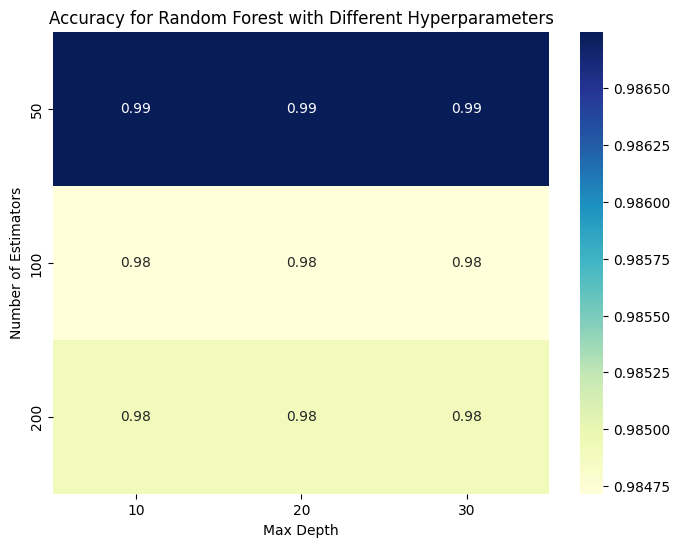

Best hyperparameters:  {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 50}
Best score:  0.9878108980444276
Test score:  0.9869451697127938


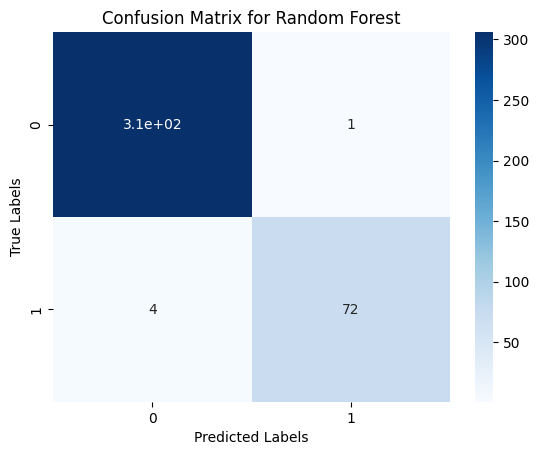

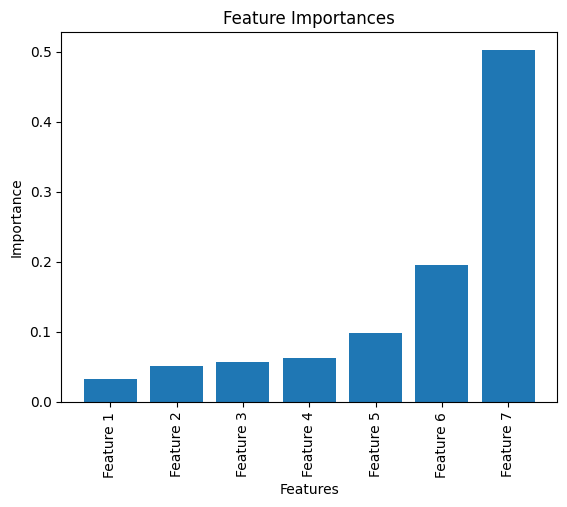

In [15]:
# Create a DataFrame to store the results
results = pd.DataFrame(grid_search.cv_results_)

# Group the data by the index and columns to aggregate
grouped_results = results.groupby(['param_n_estimators', 'param_max_depth']).mean()['mean_test_score']

# Pivot the grouped data to create a heatmap
heatmap_data = grouped_results.unstack()

# Create a heatmap to visualize the accuracy for all parameter combinations
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu')
plt.title("Accuracy for Random Forest with Different Hyperparameters")
plt.xlabel("Max Depth")
plt.ylabel("Number of Estimators")
plt.show()

# Print the best hyperparameters and the corresponding score
print("Best hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

# Evaluate the best model on the test data using the optimized hyperparameters
best_model = grid_search.best_estimator_
test_score = best_model.score(X_test, y_test)
print("Test score: ", test_score)

# Create a confusion matrix to visualize the model's performance on the test data
y_pred = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues')
plt.title("Confusion Matrix for Random Forest")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Create a bar chart to visualize the feature importances
feature_importances = best_model.feature_importances_
feature_names = [f"Feature {i+1}" for i in range(X.shape[1])]
sorted_idx = feature_importances.argsort()
plt.bar(feature_names, feature_importances[sorted_idx])
plt.title("Feature Importances")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.xticks(rotation=90)
plt.show()
